# 보스톤 집값 예측

## 패키지 로딩

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

## 데이터 로드 및 확인

In [14]:
boston = pd.read_csv('./dataset/HousingData.csv')
print(boston.shape)
display(boston.head())

boston.dropna(inplace=True)

data_x = boston.drop('MEDV', axis=1)  # 종속변수 컬럼 삭제
data_y = boston['MEDV']

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [15]:
data_x.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000
mean,3.690136,11.460660,11.000863,0.068528,0.553215,6.280015,68.932741,3.805268,9.403553,406.431472,18.537563,358.490939,12.769112
std,9.202423,23.954082,6.908364,0.252971,0.113112,0.697985,27.888705,2.098571,8.633451,168.312419,2.166460,89.283295,7.308430
min,0.006320,0.000000,0.460000,0.000000,0.389000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,2.600000,1.730000
25%,0.081955,0.000000,5.130000,0.000000,0.453000,5.879250,45.475000,2.110100,4.000000,280.250000,17.400000,376.707500,7.125000
50%,0.268880,0.000000,8.560000,0.000000,0.538000,6.201500,77.700000,3.199200,5.000000,330.000000,19.100000,392.190000,11.300000
75%,3.435973,12.500000,18.100000,0.000000,0.624000,6.605500,94.250000,5.116700,24.000000,666.000000,20.200000,396.900000,17.117500
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [16]:
data_x.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

## 학습, 평가 데이터 분리

In [17]:
scaled_data = StandardScaler().fit_transform(data_x)

x_train, x_test, y_train, y_test = train_test_split(scaled_data, data_y, test_size=0.3, random_state=10)

## 알파값 변화에 따른 회귀계abs수 및 상관계수 계산
- 알파값: 규제의 강도를 제어하는 함수, [0, inf)범위의 부동 소수점 값 사용 가능
  - alpha=0: 규제를 사용하지 않은 일반적인 선형회귀모형에서 사용하는 최소제곱법과 같아짐
- 회귀계수: 가중치값
- 상관계수: r-squared 값

In [20]:
# 규제 비교 함수
# 다양한 알파값에 따른 규제모형별 결정계수, RMSE, 가중치
def regulation_compare(alpha, model_name):
    df = pd.DataFrame()
    for a in alpha:
        print('회귀모형:', model_name)
        print('알파값:', a)

        if model_name == 'Ridge':
            model = Ridge(alpha=a)  # alpha=: 알파값 지정 
        elif model_name == 'Lasso':
            model = Lasso(alpha=a)
        elif model_name == 'ElasticNet':
            model = ElasticNet(alpha=a, l1_ratio=0.5)  # l1_ratio: ridge, lasso의 사용비율 지정

        model.fit(x_train, y_train)  # 학습
        print(f'결정계수: {model.score(x_test, y_test):.3f}')
        weight = { f:w for f, w in zip(data_x.columns, model.coef_)}  # 각 컬럼(독립변수)의 가중치 가져오기
        y_hat = model.predict(x_test) # 예측값
        print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_hat)):.2f}')  # RMSE 평가지표 값 구하기 (정답, 예측값)
        print('='*20)

        df['alpha='+str(a)] = pd.Series(weight) # 알파값이 a인 가중치에 대한 컬럼

    return df
    

## Lasso 회귀모델 생성 (L1 규제 적용)

In [21]:
alpha = [0.07, 0.1, 0.5, 1, 3]  # 작은 값부터 실행(너무 커지면 가중치가 0이 되는 특성이 많아짐)
regulation_compare(alpha, 'Lasso')
# 알파값이 0.5일 때부터 결정계수 낮아짐 -> 알파값 커지면서 제거되는 독립변수 증가, 예측에 사용되는 독립변수도 줄어든다

회귀모형: Lasso
알파값: 0.07
결정계수: 0.796
RMSE: 3.38
회귀모형: Lasso
알파값: 0.1
결정계수: 0.798
RMSE: 3.37
회귀모형: Lasso
알파값: 0.5
결정계수: 0.770
RMSE: 3.59
회귀모형: Lasso
알파값: 1
결정계수: 0.738
RMSE: 3.84
회귀모형: Lasso
알파값: 3
결정계수: 0.585
RMSE: 4.82


,alpha=0.07,alpha=0.1,alpha=0.5,alpha=1,alpha=3
CRIM,-0.786561,-0.704372,-0.170294,-0.000000,-0.000000
ZN,1.000006,0.886016,0.000000,0.000000,0.000000
INDUS,-0.158579,-0.231884,-0.000000,-0.000000,-0.000000
CHAS,0.910501,0.903754,0.616207,0.163113,0.000000
NOX,-2.196681,-2.058722,-0.427458,-0.000000,-0.000000
RM,2.694049,2.727099,2.949034,2.760012,2.085371
AGE,-0.132180,-0.060047,-0.000000,-0.000000,-0.000000
DIS,-2.905007,-2.665093,-0.161514,-0.000000,0.000000
RAD,1.884646,1.405225,-0.000000,-0.000000,-0.000000
TAX,-1.648546,-1.209126,-0.176253,-0.271523,-0.000000


## Ridge 회귀 모델 생성 (L2 규제 적용)

In [22]:
alpha = [0, 1, 5, 10, 100]  # 알파값이 커져도 가중치가 0으로 수렴되지 않음, 독립변수 제거되지 않음
regulation_compare(alpha, 'Ridge')

회귀모형: Ridge
알파값: 0
결정계수: 0.782
RMSE: 3.50
회귀모형: Ridge
알파값: 1
결정계수: 0.784
RMSE: 3.48
회귀모형: Ridge
알파값: 5
결정계수: 0.791
RMSE: 3.42
회귀모형: Ridge
알파값: 10
결정계수: 0.796
RMSE: 3.39
회귀모형: Ridge
알파값: 100
결정계수: 0.776
RMSE: 3.54


,alpha=0,alpha=1,alpha=5,alpha=10,alpha=100
CRIM,-0.978682,-0.962117,-0.907500,-0.856741,-0.615249
ZN,1.266234,1.229297,1.111122,1.006092,0.568829
INDUS,0.013387,-0.046844,-0.222760,-0.355077,-0.609314
CHAS,0.926120,0.932566,0.949906,0.960291,0.878766
NOX,-2.519046,-2.456936,-2.240145,-2.022631,-0.829313
RM,2.616783,2.630885,2.675673,2.713414,2.606679
AGE,-0.300481,-0.300826,-0.302248,-0.303599,-0.297244
DIS,-3.464894,-3.399145,-3.163826,-2.917668,-1.237731
RAD,3.005857,2.842589,2.339628,1.918355,0.305239
TAX,-2.676262,-2.507840,-2.008382,-1.619346,-0.609589


## Elastic 회귀모델 생성 ( L1 + L2 규제 적용 )

In [23]:
alpha = [0, 1, 5, 10 ,100]
regulation_compare(alpha, 'ElasticNet')

회귀모형: ElasticNet
알파값: 0
결정계수: 0.782
RMSE: 3.50
회귀모형: ElasticNet
알파값: 1
결정계수: 0.725
RMSE: 3.93
회귀모형: ElasticNet
알파값: 5
결정계수: 0.406
RMSE: 5.77
회귀모형: ElasticNet
알파값: 10
결정계수: 0.108
RMSE: 7.07
회귀모형: ElasticNet
알파값: 100
결정계수: -0.014
RMSE: 7.54


C:\Users\user\AppData\Local\Temp\ipykernel_8156\3978823124.py:16: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(x_train, y_train)  # 학습
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.173e+03, tolerance: 2.611e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


,alpha=0,alpha=1,alpha=5,alpha=10,alpha=100
CRIM,-0.978682,-0.377179,-0.075963,-0.000000,-0.0
ZN,1.266234,0.159411,0.000000,0.000000,0.0
INDUS,0.013387,-0.400150,-0.251924,-0.000000,-0.0
CHAS,0.926120,0.543796,0.000000,0.000000,0.0
NOX,-2.519046,-0.364361,-0.124030,-0.000000,-0.0
RM,2.616783,2.414444,1.038461,0.373231,0.0
AGE,-0.300481,-0.000000,-0.000000,-0.000000,-0.0
DIS,-3.464894,-0.000000,0.000000,0.000000,0.0
RAD,3.005857,-0.000000,-0.061894,-0.000000,-0.0
TAX,-2.676262,-0.436769,-0.277347,-0.000000,-0.0


# [실습] 대한민국 육군 몸무게 예측

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [27]:
data = pd.read_csv('./dataset/Army-Dataset.csv')
data.drop('Seq', axis=1, inplace=True)
print(data.shape)
display(data.head())

(59996, 6)


,Chest,Height,Waist,Head,Foot,Weight
0,96.3,185.5,82.5,57.1,28.5,73.2
1,101.9,167.2,81.2,55.0,24.2,65.1
2,99.5,179.9,99.2,56.3,28.1,93.2
3,98.6,171.4,85.9,54.5,27.4,71.6
4,94.7,176.9,78.3,58.5,26.5,67.1


In [29]:
data_x = data.drop('Weight', axis=1)
data_y = data['Weight']

In [30]:
data_x.describe()

,Chest,Height,Waist,Head,Foot
count,59996.000000,59996.000000,59996.000000,59996.000000,59996.000000
mean,95.790886,174.826050,85.702058,57.825852,26.700707
std,9.115066,5.459105,11.030444,1.857721,1.277235
min,75.000000,157.700000,41.300000,52.000000,20.600000
25%,89.100000,171.100000,77.600000,56.500000,25.900000
50%,94.700000,174.700000,84.200000,57.800000,26.700000
75%,101.400000,178.400000,92.300000,59.000000,27.500000
max,136.400000,198.200000,160.000000,63.900000,34.200000


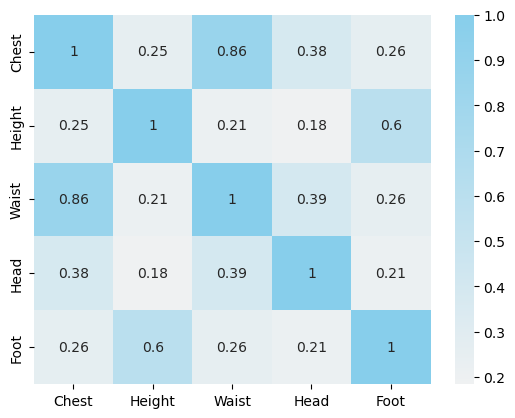

In [44]:
cmap = sns.light_palette('skyblue', as_cmap=True)
sns.heatmap(data_x.corr(), annot=True, cmap=cmap)
plt.show()

In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['VIF'] = [ variance_inflation_factor(scaled_data, i) for i in range(data_x.shape[1])]
vif['Features'] = data_x.columns
vif

,VIF,Features
0,3.978893,Chest
1,1.604806,Height
2,3.973123,Waist
3,1.210467,Head
4,1.628861,Foot


In [48]:
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, train_size=0.7)

model = LinearRegression()
model.fit(x_train, y_train)
y_hat = model.predict(x_test)
print(f'MAE: {mean_absolute_error(y_test, y_hat):.3f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_hat)):.3f}')
print(f'r2 score: {r2_score(y_test, y_hat):.3f}')

# 예측

MAE: 3.564
RMSE: 4.720
r2 score: 0.883


In [32]:
StandardScaler().fit(data_x)
scaled_data = StandardScaler().transform(data_x)

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, train_size=0.7)

model = LinearRegression()
model.fit(x_train, y_train)
y_hat = model.predict(x_test)
print(f'MAE: {mean_absolute_error(y_test, y_hat):.3f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_hat)):.3f}')
print(f'r2 score: {r2_score(y_test, y_hat):.3f}')

# 예측

# [답안]

## 패키지 로딩

In [49]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

## 데이터 로드 및 확인

In [50]:
df = pd.read_csv('./dataset/Army-Dataset.csv')

In [51]:
print(df.shape)
df.head()

(59996, 7)


,Seq,Chest,Height,Waist,Head,Foot,Weight
0,1,96.3,185.5,82.5,57.1,28.5,73.2
1,2,101.9,167.2,81.2,55.0,24.2,65.1
2,3,99.5,179.9,99.2,56.3,28.1,93.2
3,4,98.6,171.4,85.9,54.5,27.4,71.6
4,5,94.7,176.9,78.3,58.5,26.5,67.1


In [52]:
df.describe()

,Seq,Chest,Height,Waist,Head,Foot,Weight
count,59996.000000,59996.000000,59996.000000,59996.000000,59996.000000,59996.000000,59996.000000
mean,29998.500000,95.790886,174.826050,85.702058,57.825852,26.700707,71.792348
std,17319.497712,9.115066,5.459105,11.030444,1.857721,1.277235,13.799739
min,1.000000,75.000000,157.700000,41.300000,52.000000,20.600000,40.100000
25%,14999.750000,89.100000,171.100000,77.600000,56.500000,25.900000,61.800000
50%,29998.500000,94.700000,174.700000,84.200000,57.800000,26.700000,69.600000
75%,44997.250000,101.400000,178.400000,92.300000,59.000000,27.500000,79.600000
max,59996.000000,136.400000,198.200000,160.000000,63.900000,34.200000,135.000000


## 독립변수, 종속변수 분리

In [54]:
x = df.loc[:, 'Chest':'Foot']
display(x.head())

y = df['Weight']

,Chest,Height,Waist,Head,Foot
0,96.3,185.5,82.5,57.1,28.5
1,101.9,167.2,81.2,55.0,24.2
2,99.5,179.9,99.2,56.3,28.1
3,98.6,171.4,85.9,54.5,27.4
4,94.7,176.9,78.3,58.5,26.5


## 독립변수간 상관관계 확인

C:\Users\user\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


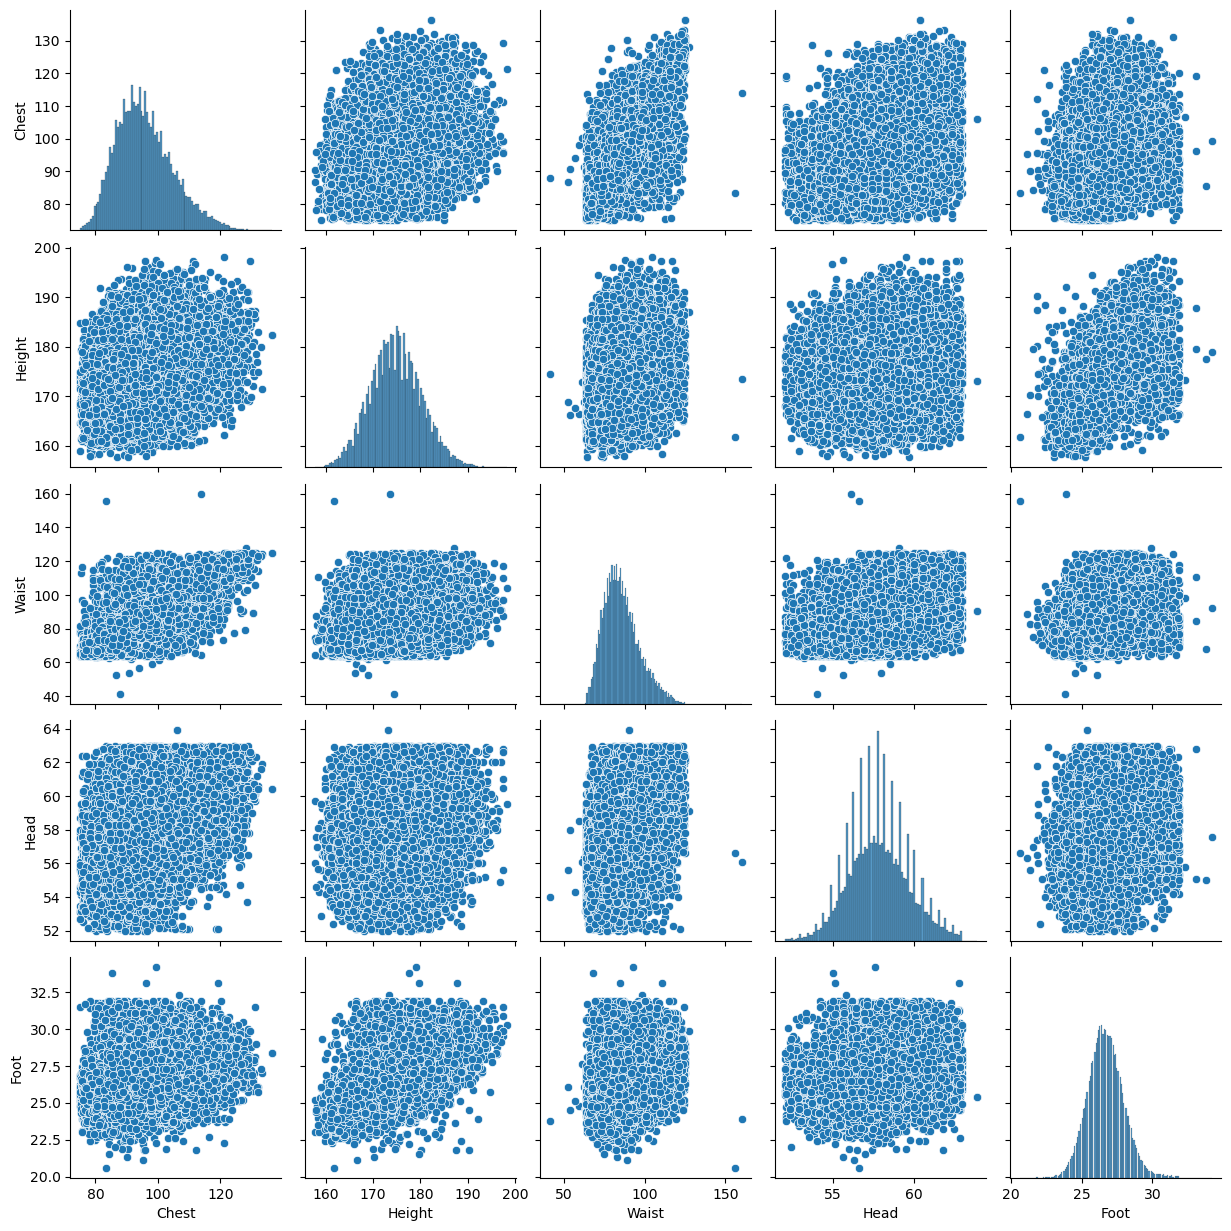

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(x)
plt.show()  # 독립변수간 선형관계 x

In [56]:
x.corr()
# 다중공선성x --> 모든 독립변수 예측에 활용

,Chest,Height,Waist,Head,Foot
Chest,1.000000,0.251119,0.861650,0.380727,0.262801
Height,0.251119,1.000000,0.214376,0.183738,0.604501
Waist,0.861650,0.214376,1.000000,0.391213,0.256374
Head,0.380727,0.183738,0.391213,1.000000,0.214197
Foot,0.262801,0.604501,0.256374,0.214197,1.000000


## 데이터 스케일링

In [59]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(x)
scaled_data = scaler.transform(x)
# fit과 transform을 분리시켜야 새로운 값 예측 시 같은 fit기준 적용 가능

## 학습, 평가 데이터 분리

In [60]:
x_train, x_test, y_train, y_test = train_test_split(scaled_data, y, train_size=0.8, random_state=10)

## 모델 생성 및 학습

In [61]:
ridge_alpha = 10
lasso_alpha = 1 
linear = LinearRegression()  # 선형회귀 모형
ridge = Ridge(alpha=ridge_alpha)  # 릿지 모형
lasso = Lasso(alpha=lasso_alpha)  # 랏소 모형

In [62]:
linear.fit(x_train, y_train)
ridge.fit(x_train, y_train)
lasso.fit(x_train, y_train)

Lasso(alpha=1)

## 예측 및 평가

In [63]:
linear_y_hat = linear.predict(x_test)
ridge_y_hat = ridge.predict(x_test)
lasso_y_hat = lasso.predict(x_test)

In [65]:
linear_r2 = r2_score(y_test, linear_y_hat)
ridge_r2 = r2_score(y_test, ridge_y_hat)
lasso_r2 = r2_score(y_test, lasso_y_hat)

linear_mae = mean_absolute_error(y_test, linear_y_hat)
ridge_mae = mean_absolute_error(y_test, ridge_y_hat)
lasso_mae = mean_absolute_error(y_test, lasso_y_hat)

print(f'R2 score - Linear: {linear_r2:.2f}, Ridge: {ridge_r2:.2f}, Lasso: {lasso_r2:2f}')
print(f'MAE score - Linear: {linear_mae:.2f}, Ridge: {ridge_mae:.2f}, Lasso: {lasso_mae:2f}')

R2 score - Linear: 0.89, Ridge: 0.89, Lasso: 0.875071
MAE score - Linear: 3.54, Ridge: 3.54, Lasso: 3.681396


In [66]:
x.iloc[0]

Chest      96.3
Height    185.5
Waist      82.5
Head       57.1
Foot       28.5
Name: 0, dtype: float64

In [67]:
new_data = np.array([90, 178, 80, 55, 26.5]).reshape(1,5)  # 2차원 데이터로 입력되어야 함
linear.predict(new_data)  # 스케일링 필요, 그냥 스케일링 안된 new data 쓰면 맞지 않음

array([1544.19172684])

In [68]:
new_data = np.array([90, 178, 80, 55, 26.5]).reshape(1,5) 
linear.predict(scaler.transform(new_data))  # 모델 학습시에 사용했던 같은 fit 기준(스케일링 학습 기준) 적용해야함

C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([65.2490275])